In [3]:
import pandas as pd
import dataprovider_pypots as dp
import process_edited as pce
import matplotlib.pyplot as plt
import torch

In [4]:
data = 'dataset/stock_data'
filename = f'{data}.csv'
real_df = pd.read_csv(filename)

real_df = real_df # You can load entire data if your memory is sufficient! 
real_df1 = real_df.drop(['date'], axis=1)
parser = pce.DataFrameParser().fit(real_df1, 1)
column_name = parser.column_name()
processed_data = torch.from_numpy(parser.transform())

data_dict = dp.UnconGen(real_df, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seq_len = 24, stride = 1)

In [5]:
import VAE as vae
import DIFF as diff

VAE_training = 10000; diff_training = 10000; lat_dim = 6; 

############ Parameter Setting ############
# pip install ipywidgets
n_epochs = VAE_training; eps = 1e-5
weight_decay = 1e-6; lr = 2e-4; hidden_size = 512; num_layers = 2; batch_size = 100
channels = 64; min_beta = 1e-5; max_beta = 0.1; emb_dim = 128; time_dim = 8; threshold = 1; device = 'cuda'

############ Auto-encoder Training ############
ds = vae.train_autoencoder(real_df1, channels, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold, min_beta, max_beta, emb_dim, time_dim, lat_dim, device, data_dict)
latent_features = ds[1]

############ Diffusion Training ############
n_epochs = diff_training; hidden_dim = 200; num_layers = 2; diffusion_steps = 100; num_classes = len(latent_features)
diff = diff.train_diffusion(latent_features, real_df1, data_dict, hidden_dim, num_layers, diffusion_steps, n_epochs, num_classes)

Output()

Output()

In [6]:
import DIFF as Diff

target_mask_test=data_dict['target_mask_test']
target_test=data_dict['response_test']
cond_test=data_dict['cond_test']
time_info_test=data_dict['time_info_test']
parser = data_dict["parser"] 

# Sampling process
device = 'cuda'
diffusion_steps = 100
Batch_size, Seq_len, _ = target_test.shape
Lat_dim = lat_dim
t_grid = torch.linspace(0, 1, Seq_len).view(1, -1, 1).to(device)
samples = Diff.sample(
    t_grid.repeat(Batch_size, 1, 1),
    Batch_size,
    Seq_len,
    Lat_dim,
    diffusion_steps,
    diff,
    time_info_test,
    cond_test,
    target_mask_test.float().to(device),
)

# Process the generated data
gen_output = ds[0].decoder(samples.to(device), target_mask_test, cond_test)
_synth_data = pce.convert_to_tensor(parser, gen_output, 1, Batch_size, Seq_len)
_real_data = pce.convert_to_table(real_df1, target_test, threshold)

B, L, K = _synth_data.shape

pd_reshaped = _real_data.reshape(B * L, K)
sd_reshaped = _synth_data.cpu().reshape(B * L, K)

real_df = pd.DataFrame(pd_reshaped.cpu().numpy())
synth_df = pd.DataFrame(sd_reshaped.cpu().numpy())

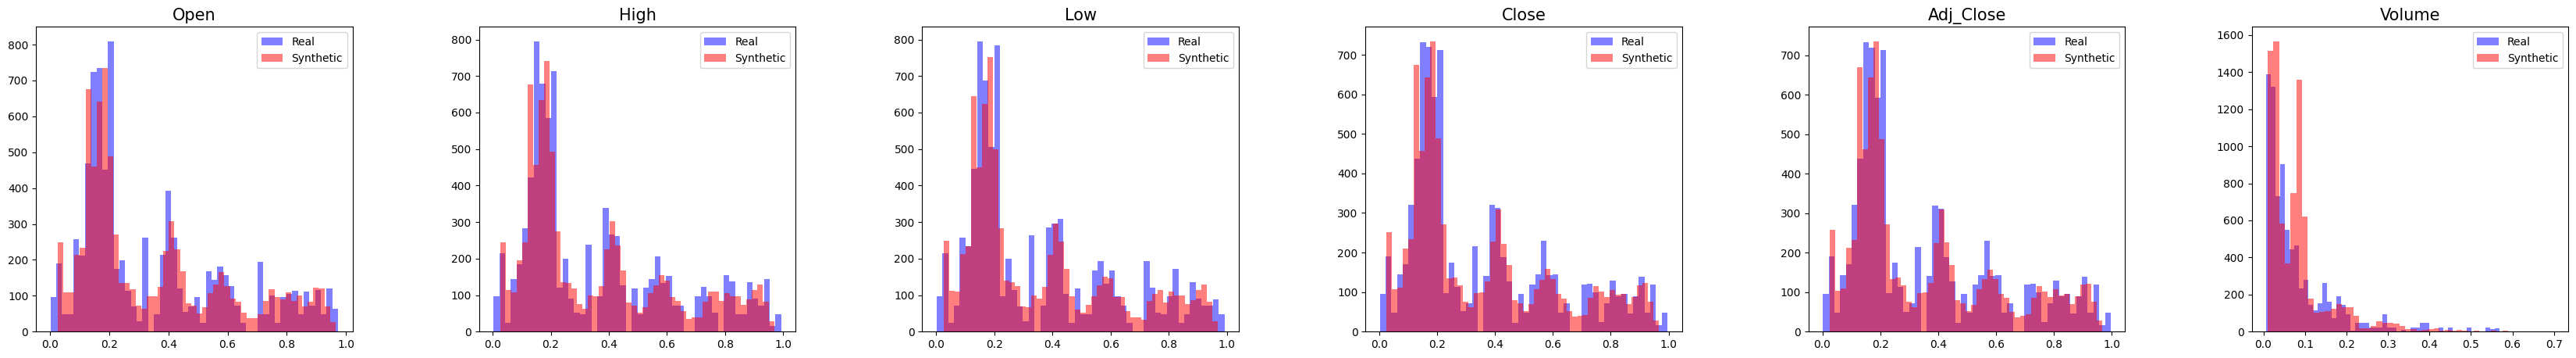

In [7]:
parser = pce.DataFrameParser().fit(real_df1, threshold)
col_name = parser.column_name()

import matplotlib.pyplot as plt
import torch
import numpy as np

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=K, figsize=(33.1, 23.4/5))

for k in range(K):
    axes[k].hist(pd_reshaped[:, k].cpu().detach(), bins=50, color='blue', alpha=0.5, label='Real')
    axes[k].hist(sd_reshaped[:, k].cpu().detach(), bins=50, color='red', alpha=0.5, label='Synthetic')

    # Adding legends
    axes[k].legend()
    axes[k].set_title(col_name[k], fontsize=15)
    
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Add space between histograms
plt.savefig('hurricane.png', dpi=500)  # Adjust dpi as needed for quality
plt.show()